## Author: Jesús Salazar Gómez, Costa Rica
## Course: Applied Data Science Capstone, week 4 and 5 (project), Coursera

## LinkedIn: https://www.linkedin.com/in/jesagocr/
## GitHub: https://github.com/jesagocr

## Table of contents:
* [Introduction, Business Problem](#Problem)
* [Data](#Data)

## Problem

In Costa Rica the Tourism is an important source of employment and generates indirectly a huge number of other jobs, it is an engine for the economy reaching up to 8.8% of the GDP and almost a 10% of the employment in the country. 
Then creating more atractive places to help the foreign people enjoy our country is a good idea, opening a business near a beach or in a community near to a beach could be a good business thanks the number of visits we have where 72% of people visit the beach or is looking for sun and beach.
Now the question for a group of businessmen who already have one restaurant in one of the most popular beaches and want to open a second one is where is a good place to open? Which other beaches are like the beach where we are located and how many restaurants exist there, how is the competition on those places. 
With the help of Python and Foursquare we will try to answer this questions and generate new insigths that will help the owners to take a decision

## Data 

Costa Rica has many beaches to visit, in this case we will scrape some pages to get info about these, their type, their features in order to understant which could be similar or what makes a beach more popular to develop venues near, also we will work with The Foursquare API to get info about the restaurants and the locals, the idea is to examine the most frequent restaurant and also what other venues there are to figure out the level of movement (economic activity) in the zone. A problem with the data or with the beaches in general is that some of them are far away of the economic center or the village because the idea is to be a relax and chill beach, but this happens because others are inside a conservation zone where there is no info about locals (venues) because they does not exist here, so we will have to try to explore other zones in the area.

In [10]:
# to read the data and do wrangling
from urllib.request import urlopen
from collections import defaultdict
from bs4 import BeautifulSoup

# to work with the api
import json
import requests
import pandas as pd


# to work with the geolocalization data
# !pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


###   Scraping some web pages

In [2]:
# reading the url
url = urlopen("https://es.wikipedia.org/wiki/Anexo:Playas_de_Costa_Rica")

In [3]:
content = str(url.read(), encoding='utf-8')
data = content.split('<li><a href="') # the info I need has: <li><a href=" 

In [88]:
# a dict with info about which places have info (I guess because are popular) and which not is a good idea.
# Also, I am going to add more categories to the dataset so a dict is perfect

d_beaches = defaultdict(dict)

for d in data[1:-1]: # the list of beaches start at index 1
    inicio = (d.find('">')+2)
    final = d.find('</')
    name = d[inicio:final]

    # it seems the most popular beaches are complete but the others are "aún no redactado"
    ini = d.find('aún no')

    if ini != -1:   # if "aún no redactado" = no info of the beach, it is possible is not a popular beach
        d_beaches[name]['Info'] = False

    else:
        d_beaches[name]['Info'] = True

print("The number of beaches is {}".format(len(d_beaches.keys())))

The number of beaches is 137


### A new web to add more categories
### There are 3 categories of beaches, use it to separete the places

In [14]:
url2 = urlopen("https://www.govisitcostarica.co.cr/travelInfo/beaches/beaches-list.asp")

In [15]:
contenido = str(url2.read(), encoding='utf-8')
types = contenido.split('<div class="pageListContentRow">') #each list of beaches are listed in a column with the class"pageList..."

In [16]:
soup = BeautifulSoup(types[1], 'html.parser') # I split the data and select the first column with data (index 1)
for d in soup.find_all('div'):                # this case it only has the categories  
    print(d.text)

Surfing Beaches
Snorkeling Beach


In [19]:
soup = BeautifulSoup(types[2], 'html.parser') # then select the second column or the second pageListContent with our data
count = 0 
cate_data = []
divider = []                                  # 2 index this case, the first div includes / covers all the beaches of 1 category 
                                              # but we can omit it and use the others div that represent just 1 beach
for d in soup.find_all('div'):                
    cate_data.append(d.text)
    
    if len(d.text) > 50: # long text means is not a name, skip
        divider.append(count)
    count = count + 1

In [20]:
surfing_b = cate_data[divider[0]+1:divider[1]]
snorkeling_b = cate_data[divider[1]+1:]

In [22]:
soup = BeautifulSoup(types[3], 'html.parser')
for d in soup.find_all('div'):
    print(d.text)

Swimming Beaches



In [23]:
soup = BeautifulSoup(types[4], 'html.parser')
count2 = 0
another_cate = []

for d in soup.find_all('div'):

    if len(d.text) > 50:
        pass
  
    else: 
        another_cate.append(d.text)
        
    count2 = count2 + 1

swimming_b = another_cate[:68] # the list with beaches ends at index 67

In [24]:
# creating a list of the beaches to match them and add the info to each beach

beaches_list = list(d_beaches.keys())

In [92]:
# I check if the beach in the list with categories appears on the dict (dataset) and add the info

ind_s = [] #if the beach appears then add the index to the list

for playa in swimming_b:
    for p in beaches_list:
        
        if playa.lower() in p.lower():
  
            ind_s.append(swimming_b.index(playa))
            d_beaches[p]['Swimming'] = True 

        else:
            cut = playa.split()[-1]  # this was my unique idea to solve the format problem (incompatibility)
            if cut.lower() in p.lower():
                ind_s.append(swimming_b.index(playa))
                d_beaches[p]['Swimming'] = True 

ind_s = set(ind_s)

In [94]:
s_beaches_no = [ x for x in swimming_b if swimming_b.index(x) not in ind_s] 
print(len(swimming_b))
print(len(s_beaches_no)) # 18 beaches from 68 did not appear or the names are different ( some beaches can be called different)

68
19


In [95]:
# I can add info manually to 4 of the 18 beaches, it could be more but it takes more time and examination. 

d_beaches['Playa Mal País']['Swimming'] = True # Malpaís
d_beaches['Playa Sámara']['Swimming'] = True   # Samara 
d_beaches['Playa Blanca']['Swimming'] = True   # PUnta Leona
d_beaches['Playa Mantas']['Swimming'] = True   # Punta Leona

In [96]:
ind_surf = []

for playa in surfing_b:
    for p in beaches_list:
        
        if playa in p:
            ind_surf.append(surfing_b.index(playa))
            d_beaches[p]['Surfing'] = True
        else:
            cut = playa.split()
            if cut[-1] in p:
                ind_surf.append(surfing_b.index(playa))
                d_beaches[p]['Surfing'] = True 

ind_surf = set(ind_surf)

In [97]:
sur_beaches_no = [ x for x in surfing_b if surfing_b.index(x) not in ind_surf] 
print(len(surfing_b))
print(len(sur_beaches_no))

38
7


In [98]:
d_beaches['Playa Mal País']['Surfing'] = True # Malpaís
d_beaches['Playa Esterillos']['Surfing'] = True

In [99]:
ind_sn = []

for playa in snorkeling_b:
    for p in beaches_list:
        if playa in p:
            ind_sn.append(snorkeling_b.index(playa))
            d_beaches[p]['Snorkeling'] = True
        else:
            cut = playa.split()
            if cut[-1] in p:
                ind_sn.append(snorkeling_b.index(playa))
                d_beaches[p]['Snorkeling'] = True 

ind_sn = set(ind_sn)

In [100]:
sn_beaches_no = [ x for x in snorkeling_b if snorkeling_b.index(x) not in ind_sn] 
print(len(snorkeling_b))
print(len(sn_beaches_no))

28
5


In [101]:
d_beaches['Playa Bahía Drake']['Snorkeling'] = True

## Trying to add more features

### 1 Nocturnal Beaches

In [37]:
# it is interesting, I try urlopen and get 403 forbidden but Beautiful was able to

source = requests.get("https://goplaya.cr/index.php/search_controller/buscar?latitud=9.935607&longitud=-84.1833856&busqueda=todas&filtros%5B%5D=81&radio=350#sa").text
soup = BeautifulSoup(source, 'html.parser')

In [38]:
info = []
for line in soup.find_all('div'):
    if line.h3 != None:
        info.append(line.h3)

In [39]:
nocturnal = []
for i in range(len(info)):
    nocturnal.append(info[i].text)

nocturnal = set(nocturnal) # the names are duplicate or even more so I have to delete duplicate values with set
nocturnal = list(nocturnal) 

In [102]:
ind_n = []

for playa in nocturnal:
    for p in beaches_list: 
        if playa in p:
            ind_n.append(nocturnal.index(playa))
            d_beaches[p]['Nocturnal'] = True
        else:
            cut = playa.split()
            if cut[-1] in p:
                ind_n.append(nocturnal.index(playa))
                d_beaches[p]['Nocturnal'] = True 

ind_n = set(ind_n)

In [103]:
no_beaches_no = [ b for b in nocturnal if nocturnal.index(b) not in ind_n] 
print(len(nocturnal))
print(len(no_beaches_no))

10
2


In [104]:
d_beaches['Playa Mal País']['Nocturnal'] = True # Malpaís

### 2 White Sand Beaches

In [46]:
source2 = requests.get("https://goplaya.cr/index.php/search_controller/buscar?latitud=9.935607&longitud=-84.1833856&busqueda=todas&filtros%5B%5D=9&radio=350#sa").text
soup2 = BeautifulSoup(source2, 'html.parser')

In [47]:
info2 = []
for line in soup2.find_all('div'):
    if line.h3 != None:
        info2.append(line.h3)

In [48]:
white_sand = []
for i in range(len(info2)):
    white_sand.append(info2[i].text.strip())

white_sand = set(white_sand)
white_sand = list(white_sand)

In [105]:
ind_ws = []

for playa in white_sand:
    for p in beaches_list:
        if playa in p:
            ind_ws.append(white_sand.index(playa))
            d_beaches[p]['White_S'] = True
        else:
            cut = playa.split()
            if cut[-1] in p:
                ind_ws.append(white_sand.index(playa))
                d_beaches[p]['White_S'] = True 

ind_ws = set(ind_ws)

In [106]:
ws_beaches_no = [ x for x in white_sand if white_sand.index(x) not in ind_ws] 
print(len(white_sand))
print(len(ws_beaches_no))

82
39


In [107]:
d_beaches['Playa Mal País']['White_S'] = True # Malpaís
d_beaches['Playa Blanca']['White_S'] = True   # PUnta Leona

In [112]:
#eliminar
df2 = pd.read_csv('beaches.csv', encoding='utf-8')
df2.head()

,Unnamed: 0,Beaches,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
0,0,Playa Barra del Colorado,True,True,True,8.515841,-83.136367,False,False,False
1,1,Playa Bonita,False,True,True,10.009861,-83.063460,True,False,False
2,2,Playa Cahuita (Blanca),False,True,True,8.515841,-83.136367,True,True,False
3,3,Playa Chiquita,True,True,True,9.637403,-82.703669,True,True,False
4,4,Punta Cocles,False,True,True,9.645276,-82.717563,True,False,False


In [113]:
#eliminar 
lat = list(df2['lati'])
lng = list(df2['long'])

In [120]:
#eliminar

l = 0

for b in beaches_list:
    d_beaches[b]['long'] = lng[l]
    l += 1

In [123]:
# eli
d_beaches['Playa Bonita']

{'Info': False,
 'White_S': True,
 'lati': 10.0098609,
 'long': -83.06345966834189}

## now I am going to add the location of each beach to be able to use the foursquare API

In [81]:
# based on the wikipedia page  

limon = beaches_list[:19]
guanacaste = beaches_list[19:87]
puntarenas = beaches_list[87:]

In [87]:

for beach in beaches_list[:70]:
    geolocator = Nominatim(user_agent="crb_explorer_js")

    if beach in limon:
        address = beach+", Limón, Costa Rica"
        #print(address)

    if beach in guanacaste:
        address = beach+", Guanacaste, Costa Rica"
        #print(address)

    if beach in puntarenas:
        address = beach+", Puntarenas, Costa Rica"
        #print(address)

    location = geolocator.geocode(address)

    if location == None:
        d_beaches[beach]['lati'] = None
        d_beaches[beach]['long'] = None
        
    else:
        d_beaches[beach]['lati'] = location.latitude
        d_beaches[beach]['long'] = location.longitude

In [89]:
for beach in beaches_list[70:]:
    geolocator = Nominatim(user_agent="cr_explorer_js")

    if beach in limon:
        address = beach+", Limón, Costa Rica"
        #print(address)

    if beach in guanacaste:
        address = beach+", Guanacaste, Costa Rica"
        #print(address)

    if beach in puntarenas:
        address = beach+", Puntarenas, Costa Rica"
        #print(address)

    location = geolocator.geocode(address)

    if location == None:
        d_beaches[beach]['lati'] = None
        d_beaches[beach]['long'] = None
        
    else:
        d_beaches[beach]['lati'] = location.latitude
        d_beaches[beach]['long'] = location.longitude

In [100]:
# Eliminar

latitudes = []

for beach in beaches_list:
    if d_beaches[beach]['lati'] == None:
        latitudes.append(beach)

In [105]:
#eliminar 
print(len(latitudes))
print(latitudes)

35
['Playa Barra del Colorado', 'Playa Cahuita (Blanca)', 'Playa Negra (Puerto Viejo)', 'Playa Pirikiki', 'Playa Puerto Vargas', 'Playa Arbolito', 'Playa Azul (Jurel)', 'Playa Buena Vista', 'Playa Carbón', 'Playa Carmen', 'Playa Cóncava', 'Playa Gringo', 'Playa Mal País', 'Playa Manzanillo (Costa Rica)', 'Playa Nabos', 'Playa Nancite', 'Playa Nubes', 'Playa Panamá (Chrorotega)', 'Playa Pietra', 'Playa Pochote (Papagayo)', 'Playa Real y Roble', 'Playa Santa Teresa', 'Playa Prieta (Papagayo)', 'Playa Pochote (Salinas)', 'Balnerario Puntarenas', 'Playa Boca Vieja', 'Playa Cabo Blanco', 'Playa de Arco', 'Playa de Doña Ana', 'Playa Garza (Boca Brava)', 'Playa Isla Damas', 'Playa Palo Seco', 'Playa Pógeres', 'Playa Quizales', 'Playa San Josecito (Golfito)']


In [107]:
# let's try without the province 

for beach in latitudes:
    geolocator = Nominatim(user_agent="beachesCR_explorer")
    address = beach+", Costa Rica"
    location = geolocator.geocode(address)

    if location == None:
        d_beaches[beach]['lati'] = None
        d_beaches[beach]['long'] = None
        
    else:
        d_beaches[beach]['lati'] = location.latitude
        d_beaches[beach]['long'] = location.longitude

In [108]:
# eli
latitudes2 = []

for beach in beaches_list:
    if d_beaches[beach]['lati'] == None:
        latitudes2.append(beach)

print(len(latitudes2))
print(latitudes2)

0
[]


In [125]:
df = pd.DataFrame(d_beaches)
df = df.transpose()
df.head()

,Info,lati,long,White_S,Swimming,Surfing,Snorkeling,Nocturnal
Playa Barra del Colorado,True,8.51584,-83.1364,NaN,NaN,NaN,NaN,NaN
Playa Bonita,False,10.0099,-83.0635,True,NaN,NaN,NaN,NaN
Playa Cahuita (Blanca),False,8.51584,-83.1364,True,True,True,True,NaN
Playa Chiquita,True,9.6374,-82.7037,True,True,NaN,True,NaN
Punta Cocles,False,9.64528,-82.7176,True,NaN,NaN,NaN,NaN


In [126]:
#df['White_S'] = df['White_S'].fillna(False)
#df['Snorkeling'] = df['Snorkeling'].fillna(False)
#df['Nocturnal'] = df['Nocturnal'].fillna(False)

# or fot the entire df
df = df.fillna(False)
df.head()

,Info,lati,long,White_S,Swimming,Surfing,Snorkeling,Nocturnal
Playa Barra del Colorado,True,8.515841,-83.136367,False,False,False,False,False
Playa Bonita,False,10.009861,-83.063460,True,False,False,False,False
Playa Cahuita (Blanca),False,8.515841,-83.136367,True,True,True,True,False
Playa Chiquita,True,9.637403,-82.703669,True,True,False,True,False
Punta Cocles,False,9.645276,-82.717563,True,False,False,False,False


In [127]:
df.reset_index(inplace=True)
df.head()

,index,Info,lati,long,White_S,Swimming,Surfing,Snorkeling,Nocturnal
0,Playa Barra del Colorado,True,8.515841,-83.136367,False,False,False,False,False
1,Playa Bonita,False,10.009861,-83.063460,True,False,False,False,False
2,Playa Cahuita (Blanca),False,8.515841,-83.136367,True,True,True,True,False
3,Playa Chiquita,True,9.637403,-82.703669,True,True,False,True,False
4,Punta Cocles,False,9.645276,-82.717563,True,False,False,False,False


In [128]:
df.rename({'index':'Beaches'}, axis=1, inplace=True)
df.head()

,Beaches,Info,lati,long,White_S,Swimming,Surfing,Snorkeling,Nocturnal
0,Playa Barra del Colorado,True,8.515841,-83.136367,False,False,False,False,False
1,Playa Bonita,False,10.009861,-83.063460,True,False,False,False,False
2,Playa Cahuita (Blanca),False,8.515841,-83.136367,True,True,True,True,False
3,Playa Chiquita,True,9.637403,-82.703669,True,True,False,True,False
4,Punta Cocles,False,9.645276,-82.717563,True,False,False,False,False


In [168]:
#to use the df other day without loading all the data
#df.to_csv('beaches.csv')

In [129]:
geolocator = Nominatim(user_agent="beachesCR_explorer")
address = "Alajuela, San Jose, Costa Rica"
location = geolocator.geocode(address)
print(location)

Alajuela, Cantón Alajuela, Provincia Alajuela, 20101, Costa Rica


In [130]:
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

10.0173148 -84.2132869


In [131]:
map_beaches = folium.Map(location=[latitude, longitude], zoom_start=8 )

for lat, lng, beach in zip(df['lati'], df['long'], df['Beaches']):
    label = '{}'.format(beach)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_beaches)  
    
map_beaches

In [ ]:
# I know the number of venues for a beach is less than the number of venues in a capital city and even less when speaking about Toronto or New York, that is why I am going to add data not just from 500 meters around the location, I am going to use 1000 meters

In [ ]:
# eliminar ******

In [ ]:
# let's explore a bit the data with some graphics

In [139]:
columns = df.columns
columns

Index(['Beaches', 'Info', 'lati', 'long', 'White_S', 'Swimming', 'Surfing',
       'Snorkeling', 'Nocturnal'],
      dtype='object')

In [135]:
%matplotlib inline 

import matplotlib.pyplot as plt 

In [140]:
col_ind = [4,5,6,7,8]

names = []
for column in range(len(columns)):
    if column in col_ind:
        names.append(columns[column])

qt = []
for i in col_ind:
    qt.append(df[columns[i]].sum())

Text(0.5, 1.0, 'Number of beaches per type')

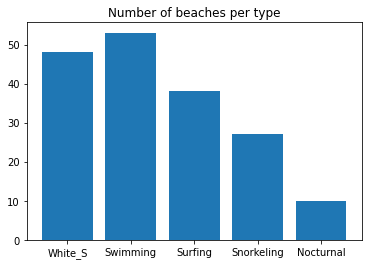

In [143]:
plt.bar(names, qt)
plt.title("Number of beaches per type")

Text(0.5, 1.0, 'Beaches per Regions')

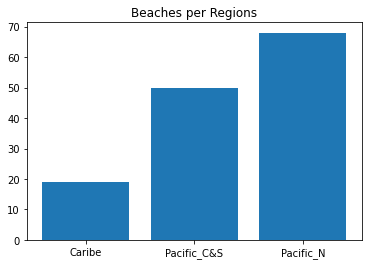

In [145]:
caribe = df2.index.to_list()[:19]
pacific_cs = df2.index.to_list()[87:]
pacific_n = df2.index.to_list()[19:87]

y = [len(caribe), len(pacific_cs), len(pacific_n)]
x = ['Caribe', 'Pacific_C&S', 'Pacific_N']

plt.bar(x,y)
plt.title("Beaches per Regions")

## all I need to continue tomorrow without loading the data again

In [3]:
df2 = pd.read_csv('beaches.csv',index_col=1, encoding='utf-8')
df2.head()

,Unnamed: 0,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
Beaches,,,,,,,,,
Playa Barra del Colorado,0,True,True,True,8.515841,-83.136367,False,False,False
Playa Bonita,1,False,True,True,10.009861,-83.063460,True,False,False
Playa Cahuita (Blanca),2,False,True,True,8.515841,-83.136367,True,True,False
Playa Chiquita,3,True,True,True,9.637403,-82.703669,True,True,False
Punta Cocles,4,False,True,True,9.645276,-82.717563,True,False,False


In [132]:
columns = df2.columns
columns

Index(['Unnamed: 0', 'Beaches', 'Info', 'Swimming', 'Surfing', 'lati', 'long',
       'White_S', 'Snorkeling', 'Nocturnal'],
      dtype='object')

In [83]:
col_ind = [2,3,6,7,8]

In [84]:
# lets try to do some plot to add to the report


In [85]:
names = []
for column in range(len(columns)):
    if column in col_ind:
        names.append(columns[column])
names

['Swimming', 'Surfing', 'White_S', 'Snorkeling', 'Nocturnal']

[137, 137, 48, 27, 10]

<BarContainer object of 5 artists>

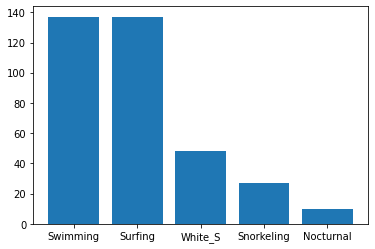

In [50]:
plt.bar(names, qt)


In [69]:
caribe = df2.index.to_list()[:19]
pacific_cs = df2.index.to_list()[87:]
pacific_n = df2.index.to_list()[19:87]

In [74]:
y = [len(caribe), len(pacific_cs), len(pacific_n)]
x = ['caribe', 'pacific_cs', 'pacific_n']

<BarContainer object of 3 artists>

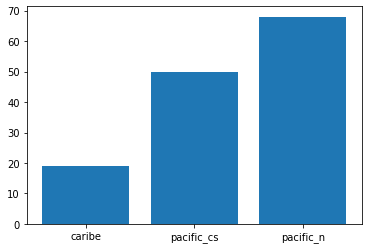

In [75]:
plt.bar(x,y)

In [101]:
df2.reset_index(inplace=True)

In [121]:
df2.head()

,Beaches,Unnamed: 0,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
0,Playa Barra del Colorado,0,True,True,True,8.515841,-83.136367,False,False,False
1,Playa Bonita,1,False,True,True,10.009861,-83.063460,True,False,False
2,Playa Cahuita (Blanca),2,False,True,True,8.515841,-83.136367,True,True,False
3,Playa Chiquita,3,True,True,True,9.637403,-82.703669,True,True,False
4,Punta Cocles,4,False,True,True,9.645276,-82.717563,True,False,False


In [130]:
# eliminar

def count_b(df,zonas):
    count = 0
  
    for i in range(10):     #(df.shape[0]):
        p = df.iloc[i,0]
        #print(p)
        if str(p) in zonas:
            print('y')
            #value = df.iloc[i,7]
            #print(value)
            #if value == True:
                #count = count + 1
    return count

In [118]:
#caribe

['Playa Barra del Colorado',
 'Playa Bonita',
 'Playa Cahuita (Blanca)',
 'Playa Chiquita',
 'Punta Cocles',
 'Playa Gandoca',
 'Playa Manzanillo',
 'Playa Moín',
 'Playa Negra (Puerto Viejo)',
 'Playa Negra (Cahuita)',
 'Playa Pirikiki',
 'Playa Portete',
 'Playa Puerto Vargas',
 'Playas Tortuguero',
 'Playa Vizcaya',
 'Playa Westfalia',
 'Puerto Viejo de Talamanca',
 'Punta Mona',
 'Punta Uva']

In [131]:
#count_b(df2, pacific_n)

0

In [135]:
#df_ws = df2[df2['White_S']==True]
#df_ws

,Beaches,Unnamed: 0,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
1,Playa Bonita,1,False,True,True,10.009861,-83.063460,True,False,False
2,Playa Cahuita (Blanca),2,False,True,True,8.515841,-83.136367,True,True,False
3,Playa Chiquita,3,True,True,True,9.637403,-82.703669,True,True,False
4,Punta Cocles,4,False,True,True,9.645276,-82.717563,True,False,False
6,Playa Manzanillo,6,False,True,True,9.633761,-82.657358,True,True,False
8,Playa Negra (Puerto Viejo),8,False,True,True,8.515841,-83.136367,True,False,False
9,Playa Negra (Cahuita),9,True,True,True,9.740670,-82.850424,True,True,False
18,Punta Uva,18,False,True,True,9.640909,-82.686332,True,False,False
20,Playa Avellanas,20,False,True,True,10.229295,-85.837797,True,False,False
22,Playa Bahía Junquillal,22,False,True,True,10.969830,-85.688038,True,True,False


In [136]:
#df_noc = df2[df2['Nocturnal'] == True]
#df_noc

,Beaches,Unnamed: 0,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
41,Playas del Coco,41,True,True,True,10.557995,-85.692262,False,True,True
55,Playa Mal País,55,False,True,True,8.515841,-83.136367,True,False,True
79,Playa Santa Teresa,79,False,True,True,8.515841,-83.136367,True,False,True
85,Playa Tamarindo,85,True,True,True,10.300854,-85.841548,True,False,True
103,Playa Dominical,103,True,True,True,9.250937,-83.864184,False,False,True
104,Playa Dominicalito,104,False,True,True,9.237396,-83.845731,False,False,True
111,Playa Jacó,111,True,True,True,9.600515,-84.621062,False,False,True
114,Playa Mata de Limón,114,False,True,True,9.932353,-84.721448,True,False,True
116,Playas Manuel Antonio,116,True,True,True,9.976200,-84.827582,True,True,True
118,Playa Montezuma,118,False,True,True,9.657497,-85.064285,True,True,True


In [137]:
#df_snork = df2[df2['Snorkeling'] == True]
#df_snork

,Beaches,Unnamed: 0,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
2,Playa Cahuita (Blanca),2,False,True,True,8.515841,-83.136367,True,True,False
3,Playa Chiquita,3,True,True,True,9.637403,-82.703669,True,True,False
6,Playa Manzanillo,6,False,True,True,9.633761,-82.657358,True,True,False
9,Playa Negra (Cahuita),9,True,True,True,9.740670,-82.850424,True,True,False
16,Puerto Viejo de Talamanca,16,True,True,True,9.656494,-82.753565,False,True,False
22,Playa Bahía Junquillal,22,False,True,True,10.969830,-85.688038,True,True,False
34,Playa Carrillo,34,True,True,True,9.868196,-85.499078,True,True,False
36,Playa Conchal,36,True,True,True,10.401501,-85.805542,True,True,False
41,Playas del Coco,41,True,True,True,10.557995,-85.692262,False,True,True
47,Playa Hermosa,47,True,True,True,10.574502,-85.674186,False,True,False


In [143]:
# 

def create_map(dframe):

    map = folium.Map(location=[latitude, longitude], zoom_start=8 )
    total_beaches = 0

    for lat, lng, beach in zip(dframe['lati'], dframe['long'], dframe['Beaches']):
        total_beaches += 1
        label = '{}'.format(beach)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='Green',
            fill=True,
            fill_color='#1186cc',
            fill_opacity=0.6,
            parse_html=False).add_to(map)  
    print(total_beaches)   

    return map

In [147]:
create_map(df_noc)

In [145]:
# create_map(df_ws)

In [146]:
# create_map(df_snork)

In [3]:
df2 = pd.read_csv('beaches.csv',index_col=1, encoding='utf-8')
df2.head()

,Unnamed: 0,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
Beaches,,,,,,,,,
Playa Barra del Colorado,0,True,True,True,8.515841,-83.136367,False,False,False
Playa Bonita,1,False,True,True,10.009861,-83.063460,True,False,False
Playa Cahuita (Blanca),2,False,True,True,8.515841,-83.136367,True,True,False
Playa Chiquita,3,True,True,True,9.637403,-82.703669,True,True,False
Punta Cocles,4,False,True,True,9.645276,-82.717563,True,False,False


In [4]:
columns = df2.columns
columns

Index(['Unnamed: 0', 'Info', 'Swimming', 'Surfing', 'lati', 'long', 'White_S',
       'Snorkeling', 'Nocturnal'],
      dtype='object')

In [5]:
df2 = df2[columns[1:]].transpose()
playas = df2.to_dict()

In [174]:
#playas

In [6]:
playas['Playa Barra del Colorado']

{'Info': True,
 'Swimming': True,
 'Surfing': True,
 'lati': 8.51584085,
 'long': -83.13636745062689,
 'White_S': False,
 'Snorkeling': False,
 'Nocturnal': False}

## until here

In [7]:
lits_p = list(playas.keys())
len(lits_p)
lits_p[:10]

['Playa Barra del Colorado',
 'Playa Bonita',
 'Playa Cahuita (Blanca)',
 'Playa Chiquita',
 'Punta Cocles',
 'Playa Gandoca',
 'Playa Manzanillo',
 'Playa Moín',
 'Playa Negra (Puerto Viejo)',
 'Playa Negra (Cahuita)']

In [217]:
# one degree in latitute and longitude is almost 110 km
# a small change in the latitute of 0.09 is almsot one 1km
110 * 0.009
# that is the small change I am going to apply in order to explore more places in with the API and not just the beach 

0.9899999999999999

In [8]:

change = 0.009

for beach in lits_p:
    newLoc = []
    #the first case I am going to chage the lat
    lati = playas[beach]['lati']
    long = playas[beach]['long']


    newLoc.append((lati-change, long))
    newLoc.append((lati+change, long))
    newLoc.append((lati, long-change))
    newLoc.append((lati, long+change))

    #print(newLoc)
    playas[beach]['other_info'] = newLoc

In [20]:
len(playas['Playa Barra del Colorado']['other_info'])

4

In [9]:
extra_explore = []
for b in lits_p:
    l = playas[b]['other_info']
    for c in l:
        #print(l)
        extra_explore.append(c)

In [10]:
len(extra_explore)

548

In [23]:
extra_explore[:10]

[(8.50684085, -83.13636745062689),
 (8.52484085, -83.13636745062689),
 (8.51584085, -83.14536745062689),
 (8.51584085, -83.12736745062689),
 (10.0008609, -83.06345966834189),
 (10.0188609, -83.06345966834189),
 (10.0098609, -83.07245966834189),
 (10.0098609, -83.05445966834189),
 (8.50684085, -83.13636745062689),
 (8.52484085, -83.13636745062689)]

In [11]:
ls_lt = []
ls_ln = []

for l in range(len(extra_explore)):
    ls_lt.append(extra_explore[l][0])
    ls_ln.append(extra_explore[l][1])

In [12]:
len(ls_lt)

548

In [278]:
df2

Beaches,Playa Barra del Colorado,Playa Bonita,Playa Cahuita (Blanca),Playa Chiquita,Punta Cocles,Playa Gandoca,Playa Manzanillo,Playa Moín,Playa Negra (Puerto Viejo),Playa Negra (Cahuita),...,Playa San Josecito (Golfito),Playa Savegre,Playa Sombrero,Playa Tamales,Playa Tambor,Playa Tárcoles,Playa Tivives,Playa Tortuga,Playa Uvita,Playa Zancudo
Info,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
Swimming,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Surfing,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
lati,8.51584,10.0099,8.51584,9.6374,9.64528,9.59989,9.63376,10.0099,8.51584,9.74067,...,8.51584,9.36369,8.41559,8.45534,9.74571,9.75939,9.92122,9.77325,9.15531,8.51584
long,-83.1364,-83.0635,-83.1364,-82.7037,-82.7176,-82.6071,-82.6574,-83.0635,-83.1364,-82.8504,...,-83.1364,-84.0706,-83.2802,-83.2805,-84.9885,-84.628,-84.7149,-84.8954,-83.7574,-83.1364
White_S,False,True,True,True,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
Snorkeling,False,False,True,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,True,True
Nocturnal,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
df2 = pd.read_csv('beaches.csv',encoding='utf-8')
df2.head()

,Unnamed: 0,Beaches,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
0,0,Playa Barra del Colorado,True,True,True,8.515841,-83.136367,False,False,False
1,1,Playa Bonita,False,True,True,10.009861,-83.063460,True,False,False
2,2,Playa Cahuita (Blanca),False,True,True,8.515841,-83.136367,True,True,False
3,3,Playa Chiquita,True,True,True,9.637403,-82.703669,True,True,False
4,4,Punta Cocles,False,True,True,9.645276,-82.717563,True,False,False


In [39]:
map_explore2 = folium.Map(location=[latitude, longitude], zoom_start=8 )

for lat, lng in zip(ls_lt, ls_ln):
    #print(lat, lng)
    #label = '{}'.format(beach)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        #popup=label,
        color='Red',
        fill=True,
        fill_color='#30115cc',
        fill_opacity=0.5).add_to(map_explore2)  

for lat, lng, beach in zip(df2['lati'], df2['long'], df2['Beaches']):
    label = '{}'.format(beach)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_explore) 
    
map_explore

## Delete

In [9]:
# eliminar

change = 0.009

for beach in lits_p:
    newLoc = []
    #the first case I am going to chage the lat
    lati = playas[beach]['lati']
    long = playas[beach]['long']

    if long > -83.6:
         newLoc.append((lati, long-change))

    else:     
        newLoc.append((lati, long+change))

    #newLoc.append((lati-change, long))
    #newLoc.append((lati+change, long))
    #print(newLoc)
    playas[beach]['other_info'] = newLoc

In [11]:
#eliminar
playas['Playa Barra del Colorado']['other_info']

[(8.51584085, -83.14536745062689)]

In [10]:
#print(playas['Playa Barra del Colorado']['lati'])
#print(playas['Playa Barra del Colorado']['long'])

8.51584085
-83.13636745062689


In [14]:
#eliminar

extra_explore = []
for b in lits_p:
    l = playas[b]['other_info']
    #print(l)
    #for c in l:
        #print(l)
    extra_explore.append(l)

In [15]:
#print(len(extra_explore))
#extra_explore[:10]

137


[[(8.51584085, -83.14536745062689)],
 [(10.0098609, -83.07245966834189)],
 [(8.51584085, -83.14536745062689)],
 [(9.637402699999999, -82.71266899999999)],
 [(9.64527615, -82.72656313437658)],
 [(9.59988715, -82.6160751340197)],
 [(9.63376115, -82.66635846713483)],
 [(10.0098609, -83.07245966834189)],
 [(8.51584085, -83.14536745062689)],
 [(9.7406696, -82.8594235)]]

In [28]:
ls_lt = []
ls_ln = []

#ind = 0
for l in extra_explore:
    #print(l[0][0])
    ls_lt.append(l[0][0])
    ls_ln.append(l[0][1])
    #ind += 1

In [41]:
ls_ln[:10]

[-83.13636745062689,
 -83.13636745062689,
 -83.14536745062689,
 -83.12736745062689,
 -83.06345966834189,
 -83.06345966834189,
 -83.07245966834189,
 -83.05445966834189,
 -83.13636745062689,
 -83.13636745062689]

In [42]:
len(ls_ln)

548

In [18]:
df2 = pd.read_csv('beaches.csv',encoding='utf-8')
df2.head()

,Unnamed: 0,Beaches,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
0,0,Playa Barra del Colorado,True,True,True,8.515841,-83.136367,False,False,False
1,1,Playa Bonita,False,True,True,10.009861,-83.063460,True,False,False
2,2,Playa Cahuita (Blanca),False,True,True,8.515841,-83.136367,True,True,False
3,3,Playa Chiquita,True,True,True,9.637403,-82.703669,True,True,False
4,4,Punta Cocles,False,True,True,9.645276,-82.717563,True,False,False


In [30]:
map_explore = folium.Map(location=[latitude, longitude], zoom_start=8 )

for lat, lng in zip(ls_lt, ls_ln):
    #print(lat, lng)
    #label = '{}'.format(beach)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        #popup=label,
        color='Red',
        fill=True,
        fill_color='#30115cc',
        fill_opacity=0.5).add_to(map_explore)  

for lat, lng, beach in zip(df2['lati'], df2['long'], df2['Beaches']):
    label = '{}'.format(beach)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color='#1186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(map_explore) 
    
map_explore

In [26]:
a = list(df2['lati'])

In [27]:
b = ls_lt
b

[8.51584085,
 10.0098609,
 8.51584085,
 9.637402699999999,
 9.64527615,
 9.59988715,
 9.63376115,
 10.0098609,
 8.51584085,
 9.7406696]

## Until here (delete)

## Now the Foursquare API to add more info 

In [36]:
CLIENT_ID = 'RZUGC5ZFLANLGWB5FEH10415WEQNYUCJGFHLA0FQQFD1GX0N' # your Foursquare ID
CLIENT_SECRET = 'BNAKVWIOXPGUKLBF3FMSANLL5USV4DEI2EZHJDVUN5ZZPWFX' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
l = 'l'
lo = 'lo'
radius = 500

In [37]:
l = df2.loc[0, 'lati'] # neighborhood latitude value
lo = df2.loc[0, 'long'] # neighborhood longitude value

name = df2.loc[0, 'Beaches'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}'.format(name,
                                                                l,
                                                                lo))

Latitude and longitude values of Playa Barra del Colorado are 8.51584085, -83.13636745062689


In [38]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    l, 
    lo, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?client_id=RZUGC5ZFLANLGWB5FEH10415WEQNYUCJGFHLA0FQQFD1GX0N&client_secret=BNAKVWIOXPGUKLBF3FMSANLL5USV4DEI2EZHJDVUN5ZZPWFX&v=20200101&ll=8.51584085,-83.13636745062689&radius=500&limit=100'

In [46]:
results = requests.get(url).json() 
results

{'meta': {'code': 200, 'requestId': '5fc6b31ae749390203747f65'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 8.520340854500004,
    'lng': -83.13182577600566},
   'sw': {'lat': 8.511340845499996, 'lng': -83.14090912524813}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4db1ca93cda14b702a4dc2a9',
       'name': 'Sol Y Mar',
       'location': {'address': '14',
        'lat': 8.519452,
        'lng': -83.1380895527337,
        'labeledLatLngs': [{'label': 'display',
          'lat': 

In [47]:
results.keys()

dict_keys(['meta', 'response'])

In [48]:
results['response']['totalResults']

2

In [49]:
len(results['response']['groups'][0]['items'])

2

In [53]:
import numpy as np
from scipy import stats

jj = np.array([1,1,1,1,1,1,31,3,2,5,2])
mode = list(stats.mode(jj))
mode[0]

array([1])

In [56]:
type(mode)
m = list(mode[0])
print(type(m))
print(m)

<class 'list'>
[1]


In [20]:
columns = df2.columns
columns

Index(['Unnamed: 0', 'Beaches', 'Info', 'Swimming', 'Surfing', 'lati', 'long',
       'White_S', 'Snorkeling', 'Nocturnal'],
      dtype='object')

In [21]:
# abrirlo sin indice
df2 = df2[columns[1:]]
df2.head()

,Beaches,Info,Swimming,Surfing,lati,long,White_S,Snorkeling,Nocturnal
0,Playa Barra del Colorado,True,True,True,8.515841,-83.136367,False,False,False
1,Playa Bonita,False,True,True,10.009861,-83.063460,True,False,False
2,Playa Cahuita (Blanca),False,True,True,8.515841,-83.136367,True,True,False
3,Playa Chiquita,True,True,True,9.637403,-82.703669,True,True,False
4,Punta Cocles,False,True,True,9.645276,-82.717563,True,False,False


In [88]:
#thanks to the week 3  I have an idea how to work this data. Let's use the code to explore the beaches

def getNearbyVenues(names, latitudes, longitudes, latitudes2, longitudes2, radius=500):
    
    venues_list=[]
    start = 0
    end = 4

    for name, lat, lng in zip(names, latitudes, longitudes):
 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items'] #venues
        except:
            pass

        #print(results)
        #qt = len(results['response']['groups'][0]['items'])
        #print(name)
        #list_qt.append(name, qt)


        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


        for lat2, lng2 in zip(latitudes2[start:end], longitudes2[start:end]):
        
            # I need a new url
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat2, 
                lng2, 
                radius, 
                LIMIT)

            try:
                results = requests.get(url).json()['response']['groups'][0]['items'] #venues
            except:
                pass

            #print(results)    
            #qt = len(results['response']['groups'][0]['items'])
            #print(name)

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat2, 
                lng2, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])            

            start += 4
            end += 4

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Beach', 
                  'Beach Latitude', 
                  'Beach Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [89]:
be_venues = getNearbyVenues(names=df2['Beaches'], 
                                  latitudes=df2['lati'],
                                longitudes=df2['long'],
                                latitudes2 = ls_lt,
                                longitudes2 = ls_ln
                                  )

Playa Barra del Colorado
Playa Barra del Colorado
Playa Barra del Colorado
Playa Barra del Colorado
Playa Barra del Colorado
Playa Bonita
Playa Bonita
Playa Bonita
Playa Bonita
Playa Bonita
Playa Cahuita (Blanca)
Playa Cahuita (Blanca)
Playa Cahuita (Blanca)
Playa Cahuita (Blanca)
Playa Cahuita (Blanca)
Playa Chiquita
Playa Chiquita
Playa Chiquita
Playa Chiquita
Playa Chiquita
Punta Cocles
Punta Cocles
Punta Cocles
Punta Cocles
Punta Cocles
Playa Gandoca
Playa Gandoca
Playa Gandoca
Playa Gandoca
Playa Gandoca
Playa Manzanillo
Playa Manzanillo
Playa Manzanillo
Playa Manzanillo
Playa Manzanillo
Playa Moín
Playa Moín
Playa Moín
Playa Moín
Playa Moín
Playa Negra (Puerto Viejo)
Playa Negra (Puerto Viejo)
Playa Negra (Puerto Viejo)
Playa Negra (Puerto Viejo)
Playa Negra (Puerto Viejo)
Playa Negra (Cahuita)
Playa Negra (Cahuita)
Playa Negra (Cahuita)
Playa Negra (Cahuita)
Playa Negra (Cahuita)
Playa Pirikiki
Playa Pirikiki
Playa Pirikiki
Playa Pirikiki
Playa Pirikiki
Playa Portete
Playa Porte

In [90]:
be_venues.head(25)

,Beach,Beach Latitude,Beach Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Playa Barra del Colorado,8.515841,-83.136367,Sol Y Mar,8.519452,-83.138090,Restaurant
1,Playa Barra del Colorado,8.515841,-83.136367,Cabinas Sol y Mar,8.519859,-83.138046,Bed & Breakfast
2,Playa Bonita,10.009861,-83.063460,Quimbamba,10.010374,-83.064016,Caribbean Restaurant
3,Playa Bonita,10.009861,-83.063460,Restaurante Cocorí,10.008688,-83.061253,Caribbean Restaurant
4,Playa Bonita,10.009861,-83.063460,Playa Bonita,10.009727,-83.063825,Beach
5,Playa Bonita,10.009861,-83.063460,Hotel Playa Bonita,10.008680,-83.061269,Bed & Breakfast
6,Playa Bonita,10.009861,-83.063460,Cocorí Bar Restaurant,10.008747,-83.061293,Caribbean Restaurant
7,Playa Bonita,10.009861,-83.063460,Junitos,10.010976,-83.063887,Caribbean Restaurant
8,Playa Bonita,10.009861,-83.063460,Reina's,10.009710,-83.063838,Seafood Restaurant
9,Playa Bonita,9.636276,-82.717563,Namuwoki Lodge,9.637851,-82.713291,Hotel


In [102]:
be_venues.to_csv('BeachandVenues.csv')

In [93]:
be_venues.shape

(809, 7)

In [104]:
items = be_venues.groupby('Beach').count()
items.reset_index(inplace=True)
n_items = items[['Beach','Venue']]
n_items.head()

,Beach,Venue
0,Balnerario Puntarenas,2
1,Playa Agujas,3
2,Playa Arbolito,7
3,Playa Avellanas,5
4,Playa Azul (Jurel),5


In [126]:
n_items.sort_values(by='Venue',ascending=False, inplace=True)
n_items.head(25)

,Beach,Venue
94,Playa Tamarindo,65
108,Puerto Viejo de Talamanca,63
17,Playa Brasilito,61
16,Playa Bonita,23
31,Playa Conchal,23
83,Playa Portete,22
106,Playas Tortuguero,22
105,Playas Manuel Antonio,21
66,Playa Negra (Cahuita),21
39,Playa Espadilla,20


In [124]:
n_items['Venue'].mean()

7.288288288288288

In [113]:
print('There are {} uniques categories.'.format(len(be_venues['Venue Category'].unique())))

There are 127 uniques categories.


In [114]:
onehot = pd.get_dummies(be_venues[['Venue Category']], prefix="", prefix_sep="")

In [118]:
l = onehot.columns
fixed_columns = [onehot.columns[13]]+list(onehot.columns[:13])+list(onehot.columns[14:])

In [120]:
onehot = onehot[fixed_columns]
onehot.head()

,Beach,Adult Boutique,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Tour Provider,Tourist Information Center,Trail,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Women's Store,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
onehot.shape

(809, 127)

In [122]:
onehot['Beach'] = be_venues['Beach']
onehot.head()

,Beach,Adult Boutique,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Tour Provider,Tourist Information Center,Trail,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Women's Store,Zoo
0,Playa Barra del Colorado,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Playa Barra del Colorado,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Playa Bonita,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Playa Bonita,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Playa Bonita,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
grouped = onehot.groupby('Beach').mean().reset_index()
grouped.head(30)

,Beach,Adult Boutique,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Tour Provider,Tourist Information Center,Trail,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Waterfront,Women's Store,Zoo
0,Balnerario Puntarenas,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,Playa Agujas,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,Playa Arbolito,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,Playa Avellanas,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,Playa Azul (Jurel),0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.2,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
5,Playa Bahía Drake,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
6,Playa Bahía Junquillal,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
7,Playa Ballena,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
8,Playa Barco Quebrado,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
9,Playa Barra del Colorado,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000,...,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [127]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [129]:
import numpy as np

In [130]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Beach']
for ind in np.arange(num_top_venues): # = range() #someday, I know I will use this code again. 
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Beach'] = grouped['Beach']

for ind in np.arange(grouped.shape[0]): # = range(), it return a tuple, I use the first element
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Beach,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Balnerario Puntarenas,Restaurant,Bed & Breakfast,Flea Market,Creperie,Cruise Ship,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Spot,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
1,Playa Agujas,Restaurant,Flea Market,Creperie,Cruise Ship,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dive Spot,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fish Market
2,Playa Arbolito,Restaurant,Beer Garden,Bed & Breakfast,Pool,Recreation Center,Grocery Store,Golf Course,Harbor / Marina,Cruise Ship,Cycle Studio,Deli / Bodega,Department Store,Gym / Fitness Center,Dessert Shop,Diner
3,Playa Avellanas,Surf Spot,Caribbean Restaurant,Beer Garden,Zoo,Dive Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Diner,Dive Bar,Dessert Shop,Department Store,Deli / Bodega,Cycle Studio
4,Playa Azul (Jurel),Bed & Breakfast,Tour Provider,Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Dive Spot,Dive Bar,Diner,Food,Dessert Shop,Department Store,Deli / Bodega,Cycle Studio
